# パッケージ


In [1]:
import pandas as pd
import datetime
import re
import os
from tqdm import tqdm
import category_encoders as ce
import pickle
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [68]:
jockey = pd.read_pickle("../Raw-Data/Jockey-Results/00409.pickle")
jockey_df = jockey["results"]
jockey_df.rename(columns=lambda x: re.sub(r"\s", "", x), inplace=True)
jockey_df.rename(columns=lambda x: re.sub(r"_", "", x), inplace=True)
jockey_df.rename(columns=lambda x: re.sub(r"^(.*)\1$", r"\1", x), inplace=True)
jockey_df.drop(0, inplace=True, axis=0)
jockey_df.drop("代表馬", inplace=True, axis=1)
jockey_df = jockey_df.astype("float64")
jockey_df["収得賞金(万円)"] = jockey_df["収得賞金(万円)"] / 1000
jockey_df["年度"] = jockey_df["年度"] / 100
jockey_df["順位"] = jockey_df["順位"] / 10
jockey_df

,年度,順位,1着,2着,3着,着外,重賞出走,重賞勝利,特別出走,特別勝利,平場出走,平場勝利,芝出走,芝勝利,ダート出走,ダート勝利,勝率,連対率,複勝率,収得賞金(万円)
1,20.20,14.4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0000
2,20.17,14.8,0.0,0.0,0.0,6.0,0.0,0.0,2.0,0.0,4.0,0.0,4.0,0.0,2.0,0.0,0.000,0.000,0.000,0.0000
3,20.16,15.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0000
4,20.15,13.9,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0000
5,20.14,14.4,0.0,1.0,0.0,6.0,0.0,0.0,2.0,0.0,5.0,0.0,5.0,0.0,2.0,0.0,0.000,0.143,0.143,0.3000
6,20.13,14.5,0.0,0.0,0.0,6.0,0.0,0.0,2.0,0.0,4.0,0.0,3.0,0.0,3.0,0.0,0.000,0.000,0.000,0.0000
7,20.12,13.9,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000,0.000,0.000,0.1500
8,20.11,13.1,1.0,0.0,0.0,23.0,0.0,0.0,7.0,0.0,17.0,1.0,17.0,0.0,7.0,1.0,0.042,0.042,0.042,1.1400
9,20.10,16.5,0.0,1.0,1.0,9.0,0.0,0.0,4.0,0.0,7.0,0.0,4.0,0.0,7.0,0.0,0.000,0.091,0.182,0.7617
10,20.09,12.1,2.0,3.0,0.0,43.0,0.0,0.0,15.0,1.0,33.0,1.0,32.0,2.0,16.0,0.0,0.042,0.104,0.104,3.5612


# 騎手データの加工

## クラス

In [228]:
class JockeyResults(Dataset):
    def __init__(self, path):
        self.jockey_data = pd.read_pickle(path)
        self.jockey_df = self.jockey_data["results"].copy()

    def check_null(self, df):
        return df.isnull().sum()

    def make_df(self):
        df = self.jockey_df.copy()
        df.rename(columns=lambda x: re.sub(r"\s", "", x), inplace=True)
        df.rename(columns=lambda x: re.sub(r"_", "", x), inplace=True)
        df.rename(columns=lambda x: re.sub(r"^(.*)\1$", r"\1", x), inplace=True)
        df.drop(0, inplace=True, axis=0)
        df.drop("代表馬", inplace=True, axis=1)
        # 欠損値を0に変換
        if self.check_null(df).sum() > 0:
            df.fillna(0, inplace=True)
        df = df.astype("float64")
        df["収得賞金(万円)"] = df["収得賞金(万円)"]
        df["年度"] = df["年度"] / 1000
        df["順位"] = df["順位"]
        df["着外"] = df["着外"]
        return df

    def save_df(self, path):
        df = self.make_df()
        df.to_pickle(path)

In [229]:
path = "../Raw-Data/Jockey-Results/00409.pickle"
jockey = JockeyResults(path)
output_path = "../Processed-Data/Jockey-Results/00409.pickle"
jockey.save_df(output_path)

In [230]:
path = "../Processed-Data/Jockey-Results/00409.pickle"
pd.read_pickle(path)

,年度,順位,1着,2着,3着,着外,重賞出走,重賞勝利,特別出走,特別勝利,平場出走,平場勝利,芝出走,芝勝利,ダート出走,ダート勝利,勝率,連対率,複勝率,収得賞金(万円)
1,2.020,144.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0
2,2.017,148.0,0.0,0.0,0.0,6.0,0.0,0.0,2.0,0.0,4.0,0.0,4.0,0.0,2.0,0.0,0.000,0.000,0.000,0.0
3,2.016,150.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0
4,2.015,139.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0
5,2.014,144.0,0.0,1.0,0.0,6.0,0.0,0.0,2.0,0.0,5.0,0.0,5.0,0.0,2.0,0.0,0.000,0.143,0.143,300.0
6,2.013,145.0,0.0,0.0,0.0,6.0,0.0,0.0,2.0,0.0,4.0,0.0,3.0,0.0,3.0,0.0,0.000,0.000,0.000,0.0
7,2.012,139.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000,0.000,0.000,150.0
8,2.011,131.0,1.0,0.0,0.0,23.0,0.0,0.0,7.0,0.0,17.0,1.0,17.0,0.0,7.0,1.0,0.042,0.042,0.042,1140.0
9,2.010,165.0,0.0,1.0,1.0,9.0,0.0,0.0,4.0,0.0,7.0,0.0,4.0,0.0,7.0,0.0,0.000,0.091,0.182,761.7
10,2.009,121.0,2.0,3.0,0.0,43.0,0.0,0.0,15.0,1.0,33.0,1.0,32.0,2.0,16.0,0.0,0.042,0.104,0.104,3561.2


## 変換


In [231]:
dir_path = "../Raw-Data/Jockey-Results"
output_dir_path = "../Processed-Data/Jockey-Results"
file_list = os.listdir(dir_path)
for jockey_file in tqdm(file_list):
    path = f"{dir_path}/{jockey_file}"
    jockey = JockeyResults(path)
    output_path = f"{output_dir_path}/{jockey_file}"
    jockey.save_df(output_path)

100%|██████████| 378/378 [00:01<00:00, 355.35it/s]


## 標準化

### データの全結合

In [232]:
dir_path = "../Processed-Data/Jockey-Results"
file_list = os.listdir(dir_path)
all_dfs = []
for jockey_file in tqdm(file_list):
    path = f"{dir_path}/{jockey_file}"
    df = pd.read_pickle(path)
    all_dfs.append(df)
df = pd.concat(all_dfs).reset_index(drop=True)
df

100%|██████████| 378/378 [00:03<00:00, 107.93it/s]


,年度,順位,1着,2着,3着,着外,重賞出走,重賞勝利,特別出走,特別勝利,平場出走,平場勝利,芝出走,芝勝利,ダート出走,ダート勝利,勝率,連対率,複勝率,収得賞金(万円)
0,2.020,144.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0
1,2.017,148.0,0.0,0.0,0.0,6.0,0.0,0.0,2.0,0.0,4.0,0.0,4.0,0.0,2.0,0.0,0.000,0.000,0.000,0.0
2,2.016,150.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0
3,2.015,139.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0
4,2.014,144.0,0.0,1.0,0.0,6.0,0.0,0.0,2.0,0.0,5.0,0.0,5.0,0.0,2.0,0.0,0.000,0.143,0.143,300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4057,2.023,136.0,1.0,0.0,0.0,7.0,0.0,0.0,5.0,1.0,3.0,0.0,6.0,1.0,2.0,0.0,0.125,0.125,0.125,1766.2
4058,2.023,152.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0
4059,2.023,152.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,1.0,0.0,0.000,0.000,0.000,0.0
4060,2.023,152.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.000,0.500,1.000,918.1


In [233]:
scaler = StandardScaler()
df_scaled = df.copy()

# 年度を除く数値列を標準化
numeric_columns = df.select_dtypes(include=["float64", "int64"]).columns
numeric_columns = numeric_columns.drop("年度")
df_scaled[numeric_columns] = scaler.fit_transform(df[numeric_columns])

df_scaled

,年度,順位,1着,2着,3着,着外,重賞出走,重賞勝利,特別出走,特別勝利,平場出走,平場勝利,芝出走,芝勝利,ダート出走,ダート勝利,勝率,連対率,複勝率,収得賞金(万円)
0,2.020,1.056560,-0.690883,-0.777074,-0.83925,-1.054135,-0.698331,-0.400273,-0.857920,-0.597302,-1.057775,-0.723559,-0.917748,-0.610329,-0.995697,-0.686245,-0.980691,-1.229210,-1.405460,-0.674036
1,2.017,1.130576,-0.690883,-0.777074,-0.83925,-1.029209,-0.698331,-0.400273,-0.843668,-0.597302,-1.036858,-0.723559,-0.896806,-0.610329,-0.980906,-0.686245,-0.980691,-1.229210,-1.405460,-0.674036
2,2.016,1.167585,-0.690883,-0.777074,-0.83925,-1.049149,-0.698331,-0.400273,-0.843668,-0.597302,-1.057775,-0.723559,-0.910768,-0.610329,-0.995697,-0.686245,-0.980691,-1.229210,-1.405460,-0.674036
3,2.015,0.964039,-0.690883,-0.777074,-0.83925,-1.044164,-0.698331,-0.400273,-0.857920,-0.597302,-1.047317,-0.723559,-0.903787,-0.610329,-0.995697,-0.686245,-0.980691,-1.229210,-1.405460,-0.674036
4,2.014,1.056560,-0.690883,-0.739688,-0.83925,-1.029209,-0.698331,-0.400273,-0.843668,-0.597302,-1.031629,-0.723559,-0.889825,-0.610329,-0.980906,-0.686245,-0.980691,0.265255,-0.284740,-0.669239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4057,2.023,0.908526,-0.658177,-0.777074,-0.83925,-1.024224,-0.698331,-0.400273,-0.800912,-0.474249,-1.042087,-0.723559,-0.882844,-0.550368,-0.980906,-0.686245,1.136120,0.077141,-0.425810,-0.645799
4058,2.023,1.204593,-0.690883,-0.777074,-0.83925,-1.054135,-0.698331,-0.400273,-0.857920,-0.597302,-1.057775,-0.723559,-0.917748,-0.610329,-0.995697,-0.686245,-0.980691,-1.229210,-1.405460,-0.674036
4059,2.023,1.204593,-0.690883,-0.777074,-0.83925,-1.044164,-0.698331,-0.400273,-0.857920,-0.597302,-1.047317,-0.723559,-0.910768,-0.610329,-0.988302,-0.686245,-0.980691,-1.229210,-1.405460,-0.674036
4060,2.023,1.204593,-0.690883,-0.739688,-0.79838,-1.059120,-0.698331,-0.400273,-0.843668,-0.597302,-1.057775,-0.723559,-0.917748,-0.610329,-0.988302,-0.686245,-0.980691,3.996193,6.431743,-0.659358


In [235]:
# スケーラーモデルを保存
scaler_path = "../models/v2/jockey_scaler.joblib"
os.makedirs(os.path.dirname(scaler_path), exist_ok=True)
joblib.dump(scaler, scaler_path)

['../models/v2/jockey_scaler.joblib']

In [3]:
# スケーラーモデルを読み込んで確認
loaded_scaler = joblib.load("../models/v2/jockey_scaler.joblib")
with open("../models/v2/jockey_scaler.pickle", "wb") as f:
    pickle.dump(loaded_scaler, f)

## 標準化を組み込んだクラス

In [246]:
class JockeyResults(Dataset):
    def __init__(self, path):
        self.jockey_data = pd.read_pickle(path)
        self.jockey_df = self.jockey_data["results"].copy()
        self.scaler = joblib.load("../models/v2/jockey_scaler.joblib")

    def check_null(self, df):
        return df.isnull().sum()

    def make_df(self):
        df = self.jockey_df.copy()
        df.rename(columns=lambda x: re.sub(r"\s", "", x), inplace=True)
        df.rename(columns=lambda x: re.sub(r"_", "", x), inplace=True)
        df.rename(columns=lambda x: re.sub(r"^(.*)\1$", r"\1", x), inplace=True)
        if len(df) > 1:
            df.drop(0, inplace=True, axis=0)
        df.drop("代表馬", inplace=True, axis=1)
        # 欠損値を0に変換
        if self.check_null(df).sum() > 0:
            df.fillna(0, inplace=True)
        df = df.astype("float64")
        df["収得賞金(万円)"] = df["収得賞金(万円)"]
        df["年度"] = df["年度"] / 1000
        df["順位"] = df["順位"]
        df["着外"] = df["着外"]
        return df

    def save_df(self, path):
        df = self.make_df()
        # 年度を除く数値列を標準化
        numeric_columns = df.select_dtypes(include=["float64", "int64"]).columns
        numeric_columns = numeric_columns.drop("年度")
        df[numeric_columns] = self.scaler.transform(df[numeric_columns])
        df.to_pickle(path)

In [248]:
path = "../Raw-Data/Jockey-Results/05523.pickle"
jockey = JockeyResults(path)
output_path = "../Processed-Data/Jockey-Results/05523.pickle"
jockey.save_df(output_path)

In [249]:
pd.read_pickle(output_path)

,年度,順位,1着,2着,3着,着外,重賞出走,重賞勝利,特別出走,特別勝利,平場出走,平場勝利,芝出走,芝勝利,ダート出走,ダート勝利,勝率,連対率,複勝率,収得賞金(万円)
0,2.015,0.964039,-0.690883,-0.777074,-0.83925,-1.054135,-0.698331,-0.400273,-0.85792,-0.597302,-1.057775,-0.723559,-0.917748,-0.610329,-0.995697,-0.686245,-0.980691,-1.22921,-1.40546,-0.674036


## 変換&標準化

In [250]:
dir_path = "../Raw-Data/Jockey-Results"
output_dir_path = "../Processed-Data/Jockey-Results"
file_list = os.listdir(dir_path)
for jockey_file in tqdm(file_list):
    path = f"{dir_path}/{jockey_file}"
    jockey = JockeyResults(path)
    output_path = f"{output_dir_path}/{jockey_file}"
    try:
        jockey.save_df(output_path)
    except Exception as e:
        print(f"Error processing file {path}: {e}")
        break

100%|██████████| 378/378 [00:01<00:00, 196.10it/s]


# 次元圧縮

## AE

In [2]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_layers=2, dropout=0.1):
        """
        Args:
            input_dim (int): 入力データの次元数（特徴量の数）
            hidden_dim (int): 隠れ層のユニット数
            latent_dim (int): 潜在空間の次元数（圧縮後の次元数）
            num_layers (int): GRUの層数
            dropout (float): ドロップアウト率
        """
        super(AutoEncoder, self).__init__()

        self.encoder_gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True,
        )
        self.fc_mu = nn.Linear(hidden_dim * 2, latent_dim)

        self.decoder_fc = nn.Linear(latent_dim, hidden_dim * 2)
        self.decoder_gru = nn.GRU(
            input_size=hidden_dim * 2,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True,
        )
        self.output_layer = nn.Linear(hidden_dim * 2, input_dim)

    def encode(self, x):
        _, h_n = self.encoder_gru(x)
        h_n = h_n[-2:].transpose(0, 1).contiguous()
        h_n = h_n.view(h_n.size(0), -1)
        z = self.fc_mu(h_n)
        return z

    def decode(self, z, seq_len):
        h = self.decoder_fc(z)
        h = h.unsqueeze(1).repeat(1, seq_len, 1)
        output, _ = self.decoder_gru(h)
        output = self.output_layer(output)
        return output

    def forward(self, x):
        z = self.encode(x)
        output = self.decode(z, x.size(1))
        return output

## 損失関数

In [3]:
def ae_loss(recon_x, x):
    reconstruction_loss = F.mse_loss(recon_x, x, reduction="sum")
    return reconstruction_loss

## データセットクラス

In [4]:
class TimeSeriesDataset(Dataset):
    def __init__(self, file_paths):
        self.file_paths = file_paths

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        df = pd.read_pickle(self.file_paths[idx])
        data_tensor = torch.tensor(df.values, dtype=torch.float32).unsqueeze(0)
        return data_tensor


def collate_fn(batch):
    # バッチ内の最大系列長を取得
    max_len = max([x.size(1) for x in batch])

    # パディング処理とマスクの作成
    padded_batch = []
    attention_masks = []
    for x in batch:
        seq_len = x.size(1)
        if seq_len < max_len:
            padding = torch.zeros(1, max_len - seq_len, x.size(2))
            x_padded = torch.cat([padding, x], dim=1)
            mask = torch.cat([torch.zeros(max_len - seq_len), torch.ones(seq_len)])
        else:
            x_padded = x
            mask = torch.ones(max_len)
        padded_batch.append(x_padded)
        attention_masks.append(mask)

    return {
        "input": torch.cat(padded_batch, dim=0),
        "attention_mask": torch.stack(attention_masks),
    }

In [5]:
test_df = pd.read_pickle("../Processed-Data/Jockey-Results/00409.pickle")

# データフレームをテンソルに変換
data_tensor = torch.tensor(test_df.values, dtype=torch.float64)
data_tensor.size()

torch.Size([25, 20])

In [6]:
file_names = os.listdir("../Processed-Data/Jockey-Results")
file_paths = list(map(lambda x: "../Processed-Data/Jockey-Results/" + x, file_names))
# データセット全体の系列長を確認
max_lengths = []

for path in tqdm(file_paths):
    try:
        df = pd.read_pickle(path)
        max_lengths.append(len(df))
    except Exception as e:
        print(f"Error processing file {path}: {e}")
        break

print(f"最大系列長: {max(max_lengths)}")
print(f"平均系列長: {sum(max_lengths)/len(max_lengths)}")
print(f"系列長の分布: \n{pd.Series(max_lengths).describe()}")
print(f"データサイズ: {torch.tensor(df.values, dtype=torch.float64).size()}")

100%|██████████| 378/378 [00:00<00:00, 2420.88it/s]

最大系列長: 40
平均系列長: 10.748677248677248
系列長の分布: 
count    378.000000
mean      10.748677
std        9.836208
min        1.000000
25%        2.000000
50%        7.000000
75%       18.000000
max       40.000000
dtype: float64
データサイズ: torch.Size([1, 20])


## optunaによる調整

In [262]:
file_names = os.listdir("../Processed-Data/Jockey-Results")
file_paths = list(map(lambda x: "../Processed-Data/Jockey-Results/" + x, file_names))
train_paths, test_paths = train_test_split(file_paths, test_size=0.3)
train_paths, val_paths = train_test_split(train_paths, test_size=0.2)

# カスタムデータセットのインスタンス化
train_dataset = TimeSeriesDataset(train_paths)
val_dataset = TimeSeriesDataset(val_paths)
test_dataset = TimeSeriesDataset(test_paths)

# データローダーの設定
batch_size = 16
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn
)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


def objective(trial):
    # ハイパーパラメータの設定
    lr = trial.suggest_float("lr", 1e-7, 1e-1, log=True)
    hidden_dim = trial.suggest_int("hidden_dim", 5, 20)
    latent_dim = trial.suggest_int("latent_dim", 5, 15, log=True)
    num_layers = trial.suggest_int("num_layers", 2, 10)
    dropout = trial.suggest_float("dropout", 0.0, 0.3)

    # モデルとオプティマイザの設定
    model = AutoEncoder(
        input_dim=20,
        hidden_dim=hidden_dim,
        latent_dim=latent_dim,
        num_layers=num_layers,
        dropout=dropout,
    )
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    # 訓練ループ
    for epoch in range(20):  # エポック数は適宜調整
        model.train()
        for batch in train_loader:
            input_data = batch["input"].to(device)

            optimizer.zero_grad()
            recon_batch = model(input_data)
            loss = ae_loss(recon_batch, input_data)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

    # 検証データセットでの性能評価
    return loss.item()

cuda


In [265]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)  # 試行回数は適宜調整

# 最適なハイパーパラメータを取得
best_params = study.best_params
best_value = study.best_trial.value
print("最適なハイパーパラメータ:", best_params)
print("最適な試行の値:", best_value)

[I 2025-02-12 22:47:57,117] A new study created in memory with name: no-name-9a0f56c9-3bda-46db-8bb7-f4d0fe16056e
[I 2025-02-12 22:48:02,597] Trial 0 finished with value: 66.17481231689453 and parameters: {'lr': 0.0009875454907074493, 'hidden_dim': 12, 'latent_dim': 10, 'num_layers': 8, 'dropout': 0.1905587313101829}. Best is trial 0 with value: 66.17481231689453.
[I 2025-02-12 22:48:06,171] Trial 1 finished with value: 281.4278259277344 and parameters: {'lr': 0.0005778793597187091, 'hidden_dim': 9, 'latent_dim': 6, 'num_layers': 3, 'dropout': 0.23424571674091485}. Best is trial 0 with value: 66.17481231689453.
[I 2025-02-12 22:48:09,337] Trial 2 finished with value: 253.94500732421875 and parameters: {'lr': 2.7448816338714592e-05, 'hidden_dim': 14, 'latent_dim': 5, 'num_layers': 2, 'dropout': 0.16437991302984775}. Best is trial 0 with value: 66.17481231689453.
[I 2025-02-12 22:48:13,876] Trial 3 finished with value: 276.6318664550781 and parameters: {'lr': 5.851498023108188e-05, 'hidd

最適なハイパーパラメータ: {'lr': 0.0009875454907074493, 'hidden_dim': 12, 'latent_dim': 10, 'num_layers': 8, 'dropout': 0.1905587313101829}
最適な試行の値: 66.17481231689453


旧  
最適なハイパーパラメータ: {'lr': 0.0001486600443167907, 'hidden_dim': 18, 'latent_dim': 9, 'num_layers': 5, 'dropout': 0.16891530860149706}  
最適な試行の値: 54.261871337890625  
  
新  
最適なハイパーパラメータ: {'lr': 0.0009875454907074493, 'hidden_dim': 12, 'latent_dim': 10, 'num_layers': 8, 'dropout': 0.1905587313101829}  
最適な試行の値: 66.17481231689453

training to cuda
Epoch 0, Train Loss: 239.51862092944683, Val Loss: 181.38030341886125
Epoch 50, Train Loss: 83.7005402262177, Val Loss: 57.39179625601139
Epoch 100, Train Loss: 68.33998229040354, Val Loss: 46.773567541590275
Epoch 150, Train Loss: 61.99403475359153, Val Loss: 44.31003053233309
Epoch 200, Train Loss: 56.38128508436736, Val Loss: 44.72958474789026
Epoch 250, Train Loss: 52.19076653792395, Val Loss: 41.01860769739691
Epoch 299, Train Loss: 50.889139193494174, Val Loss: 40.24864599839697


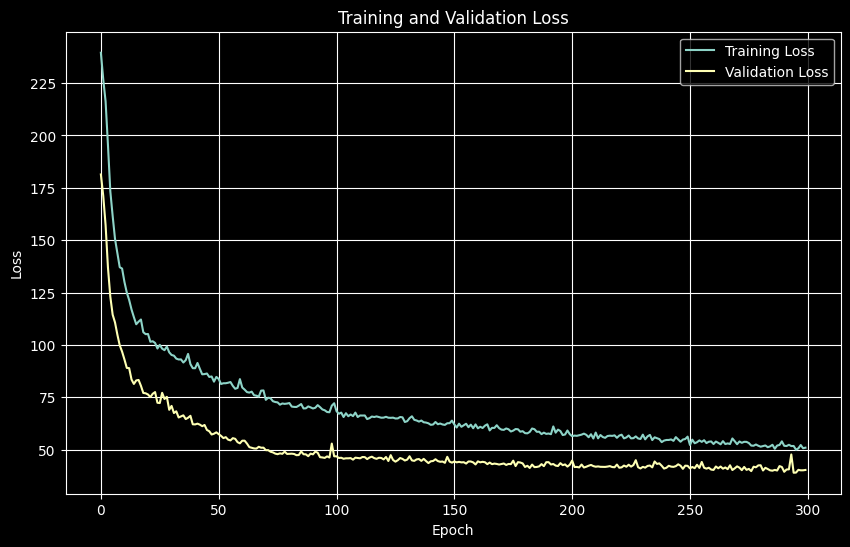

In [9]:
file_names = os.listdir("../Processed-Data/Jockey-Results")
file_paths = list(map(lambda x: "../Processed-Data/Jockey-Results/" + x, file_names))
train_paths, test_paths = train_test_split(file_paths, test_size=0.3)
train_paths, val_paths = train_test_split(train_paths, test_size=0.2)

# カスタムデータセットのインスタンス化
train_dataset = TimeSeriesDataset(train_paths)
val_dataset = TimeSeriesDataset(val_paths)
test_dataset = TimeSeriesDataset(test_paths)

# データローダーの設定
batch_size = 4
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn
)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

"""
'lr': 0.0001486600443167907,
'hidden_dim': 18,
'latent_dim': 9,
'num_layers': 5,
'dropout': 0.16891530860149706
"""
# GPUが使える場合はGPU上で動かす
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"training to {device}")
# モデルのインスタンス化
model = AutoEncoder(
    input_dim=20,
    hidden_dim=18,
    latent_dim=9,
    num_layers=5,
    dropout=0.16891530860149706,
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001486600443167907)

# エポック数
num_epochs = 300
# 評価を行うエポック数
eval_interval = 50

# 誤差を記録するリスト
train_losses = []
val_losses = []

# 訓練
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        input_data = batch["input"].to(device)
        optimizer.zero_grad()
        recon_batch = model(input_data)
        loss = ae_loss(recon_batch, input_data)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    # エポックごとの平均誤差を計算
    avg_train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # 一定のエポック数ごとに検証データセットでモデルを評価
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_batch in val_loader:
            val_input = val_batch["input"].to(device)
            recon_batch = model(val_input)
            loss = ae_loss(recon_batch, val_input)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)

    if epoch % eval_interval == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")

    # 検証データの誤差が訓練データの誤差より10%以上高い場合は早期終了
    if avg_val_loss > avg_train_loss * 1.1:
        print("Early stopping: Validation loss is 10% higher than training loss")
        break


# 学習曲線をプロット
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_losses)), train_losses, label="Training Loss")
plt.plot(range(len(val_losses)), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
model.eval()
test_loss = 0
with torch.no_grad():
    for test_batch in test_loader:
        test_input = test_batch["input"].to(device)
        recon_batch = model(test_input)
        loss = ae_loss(recon_batch, test_input)
        test_loss += loss.item()

test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss}")

Test Loss: 76.52962704708702


In [13]:
model.eval()
test_df = pd.read_pickle("../Processed-Data/Jockey-Results/00409.pickle")
test_df = test_df.iloc[:].astype("float32")
# データフレームをテンソルに変換してGPUに転送
data = torch.tensor(test_df.values, dtype=torch.float32).unsqueeze(0).to(device)

# 潜在変数の取得
with torch.no_grad():
    encoded = model.encode(data)

print(f"入力データサイズ: {data.size()}")
print(f"潜在変数サイズ: {encoded.size()}")
print("\n潜在変数:")
print(encoded.cpu().numpy())

入力データサイズ: torch.Size([1, 25, 20])
潜在変数サイズ: torch.Size([1, 9])

潜在変数:
[[ 0.41178644 -0.2513677   2.0792935   0.34708387  0.6442975   0.1500118
  -0.29772592  0.70900834 -0.23543167]]


In [14]:
torch.save(model.state_dict(), "../models/v2/jockey_result_AE.pth")

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoEncoder(
    input_dim=20,
    hidden_dim=18,
    latent_dim=9,
    num_layers=5,
    dropout=0.16891530860149706,
).to(device)
model.load_state_dict(torch.load("../models/v2/jockey_result_AE.pth"))
model.eval()
test_df = pd.read_pickle("../Processed-Data/Jockey-Results/00409.pickle")
test_df = test_df.iloc[:].astype("float32")
# データフレームをテンソルに変換してGPUに転送
data = torch.tensor(test_df.values, dtype=torch.float32).unsqueeze(0).to(device)
# 潜在変数の取得
with torch.no_grad():
    encoded = model.encode(data)
print(f"入力データサイズ: {data.size()}")
print(f"潜在変数サイズ: {encoded.size()}")
print("\n潜在変数:")
print(encoded.cpu().numpy())

入力データサイズ: torch.Size([1, 25, 20])
潜在変数サイズ: torch.Size([1, 9])

潜在変数:
[[ 0.41178644 -0.2513677   2.0792935   0.34708387  0.6442975   0.1500118
  -0.29772592  0.70900834 -0.23543167]]
